In [2]:
import sys, os
import argparse
import re
import time
from Deconvolution.BLADE import Framework
import numpy as np
from numpy import transpose as t
import itertools
import pickle
from scipy.optimize import nnls
from scipy.stats import gaussian_kde
from matplotlib.colors import LogNorm
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error 
import pandas as pd
from tqdm import trange,tqdm
# modules for visualization
import qgrid
from matplotlib import pyplot as plt
import seaborn as sns
import anndata as ad
import scanpy as sc
import scanorama
from sklearn.model_selection import LeaveOneOut,StratifiedKFold,KFold
import cycler
from sklearn.metrics import r2_score

In [3]:
def getloclist(wd,keyword=["celltypefrac"],mode='strict'):
    # strict mode
    loc_list = []
    if mode == 'strict':
        for root, dirs, files in os.walk(wd):
            for file in files:
                bool_add = False
                for key in keyword:
                    if key in file:
                        bool_add = True
                    elif key not in file:
                        bool_add = False
                        break
                if bool_add:
                    loc = os.path.join(root, file)
                    loc_list.append(loc) #get file location
    elif mode == 'lenient':
        for root, dirs, files in os.walk(wd):
            for file in files:
                for key in keyword:
                    if key in file:
                        loc = os.path.join(root, file)
                        loc_list.append(loc) #get file location
                        break
    return loc_list

### Prepare scRNA signature file for CIBERSORTx input
Run BayesPrism first to get signature.csv file in place

In [20]:
# Prepare scRNA signature file for CIBERSORTx input
# Run BayesPrism first to get signature.csv file in place
def prepare_CIBERSORTx(path_label,path_signature):
    labels = pd.read_csv(path_label+"cellcategory_simple.csv",index_col=0)
    dict_label = labels.to_dict()['cell_category']
    if "_toCIBERSORTx.tsv" in path_signature:
        print("duplicate run, no effect! remove all toCIBERSORTx file first!")
    else:
        scRNAref =  pd.read_csv(path_signature,index_col=0)
        scRNAref.columns = scRNAref.columns.map(dict_label)
        scRNAref.to_csv(path_signature.split(".")[0]+"_toCIBERSORTx.tsv",sep='\t')
        print("upload file:",path_signature.split(".")[0]+"_toCIBERSORTx.tsv","to CIBERSORTx as input")
    # see preapare_BLADE for test set, signature file from runBP 

In [21]:
# CAUTIONS! this is not part of the script but you need to run it in notebook after the pipeline script finishes
# reset keyword at new run!
list_CIBERSORTx_signature = getloclist("/home/cke/PseudoBulk/Results/",keyword=["Jul28","_signature"],mode='strict')
# list_CIBERSORTx_signature = getloclist("/home/cke/Real/TCGAResults/",keyword=["Jul28","signature"],mode='strict')

for i in tqdm(list_CIBERSORTx_signature):
    prepare_CIBERSORTx("/home/cke/Puram/scRNAlabels/",i)
print(len(list_CIBERSORTx_signature))

  2%|█▊                                                                                  | 1/45 [00:02<02:01,  2.77s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top100markers_6LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


  4%|███▋                                                                                | 2/45 [00:05<01:52,  2.61s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top100DEGs_26LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


  7%|█████▌                                                                              | 3/45 [00:06<01:23,  1.99s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top50markers_26LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


  9%|███████▍                                                                            | 4/45 [00:07<00:58,  1.42s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top20markers_20LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 11%|█████████▎                                                                          | 5/45 [00:08<00:57,  1.45s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top50DEGs_22LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 13%|███████████▏                                                                        | 6/45 [00:09<00:44,  1.14s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top20markers_28LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 16%|█████████████                                                                       | 7/45 [00:10<00:47,  1.24s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top50markers_22LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 18%|██████████████▉                                                                     | 8/45 [00:11<00:38,  1.05s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top20markers_6LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 20%|████████████████▊                                                                   | 9/45 [00:11<00:32,  1.11it/s]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top20markers_17LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 22%|██████████████████▍                                                                | 10/45 [00:14<00:46,  1.33s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top100DEGs_20LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 24%|████████████████████▎                                                              | 11/45 [00:16<01:00,  1.78s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top100DEGs_22LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 27%|██████████████████████▏                                                            | 12/45 [00:18<00:53,  1.62s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top50markers_18LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 29%|███████████████████████▉                                                           | 13/45 [00:20<00:58,  1.83s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top100markers_28LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 31%|█████████████████████████▊                                                         | 14/45 [00:21<00:51,  1.65s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top50markers_17LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 33%|███████████████████████████▋                                                       | 15/45 [00:22<00:46,  1.55s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top50DEGs_26LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 36%|█████████████████████████████▌                                                     | 16/45 [00:24<00:44,  1.52s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top50DEGs_6LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 38%|███████████████████████████████▎                                                   | 17/45 [00:26<00:50,  1.80s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top100markers_18LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 40%|█████████████████████████████████▏                                                 | 18/45 [00:28<00:43,  1.63s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top50DEGs_20LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 42%|███████████████████████████████████                                                | 19/45 [00:29<00:38,  1.50s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top50markers_28LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 44%|████████████████████████████████████▉                                              | 20/45 [00:31<00:43,  1.76s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top100DEGs_25LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 47%|██████████████████████████████████████▋                                            | 21/45 [00:32<00:38,  1.61s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top50DEGs_28LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 49%|████████████████████████████████████████▌                                          | 22/45 [00:34<00:33,  1.48s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top50markers_20LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 51%|██████████████████████████████████████████▍                                        | 23/45 [00:35<00:31,  1.43s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top50DEGs_17LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 53%|████████████████████████████████████████████▎                                      | 24/45 [00:36<00:28,  1.37s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top50markers_16LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 56%|██████████████████████████████████████████████                                     | 25/45 [00:39<00:33,  1.68s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top100DEGs_16LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 58%|███████████████████████████████████████████████▉                                   | 26/45 [00:39<00:25,  1.35s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top20markers_26LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 60%|█████████████████████████████████████████████████▊                                 | 27/45 [00:41<00:29,  1.66s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top100markers_17LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 62%|███████████████████████████████████████████████████▋                               | 28/45 [00:43<00:26,  1.55s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top50DEGs_16LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 64%|█████████████████████████████████████████████████████▍                             | 29/45 [00:45<00:27,  1.75s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top100markers_20LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 67%|███████████████████████████████████████████████████████▎                           | 30/45 [00:46<00:21,  1.42s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top20markers_22LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 69%|█████████████████████████████████████████████████████████▏                         | 31/45 [00:46<00:16,  1.17s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top20markers_18LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 71%|███████████████████████████████████████████████████████████                        | 32/45 [00:49<00:20,  1.56s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top100DEGs_17LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 73%|████████████████████████████████████████████████████████████▊                      | 33/45 [00:50<00:17,  1.48s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top50DEGs_18LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 76%|██████████████████████████████████████████████████████████████▋                    | 34/45 [00:51<00:13,  1.20s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top20markers_25LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 78%|████████████████████████████████████████████████████████████████▌                  | 35/45 [00:53<00:15,  1.56s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top100markers_26LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 80%|██████████████████████████████████████████████████████████████████▍                | 36/45 [00:55<00:15,  1.76s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top100markers_25LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 82%|████████████████████████████████████████████████████████████████████▏              | 37/45 [00:58<00:16,  2.01s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top100DEGs_18LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 84%|██████████████████████████████████████████████████████████████████████             | 38/45 [00:59<00:12,  1.78s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top50DEGs_25LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 87%|███████████████████████████████████████████████████████████████████████▉           | 39/45 [01:00<00:09,  1.66s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top50markers_6LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 89%|█████████████████████████████████████████████████████████████████████████▊         | 40/45 [01:01<00:06,  1.33s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top20markers_16LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 91%|███████████████████████████████████████████████████████████████████████████▌       | 41/45 [01:03<00:06,  1.63s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top100markers_16LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 93%|█████████████████████████████████████████████████████████████████████████████▍     | 42/45 [01:04<00:04,  1.50s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top50markers_25LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 96%|███████████████████████████████████████████████████████████████████████████████▎   | 43/45 [01:07<00:03,  1.88s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top100markers_22LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


 98%|█████████████████████████████████████████████████████████████████████████████████▏ | 44/45 [01:10<00:02,  2.13s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top100DEGs_6LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input


100%|███████████████████████████████████████████████████████████████████████████████████| 45/45 [01:12<00:00,  1.62s/it]

upload file: /home/cke/PseudoBulk/Results/fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top100DEGs_28LOT_signature_toCIBERSORTx.tsv to CIBERSORTx as input
45


In [4]:
real_res = pd.read_csv("/home/cke/MuSic/celltypefrac_real_pseudobulk.csv",index_col=0)
real_res

,B-cell,Dendritic,Endothelial,Fibroblast,Macrophage,Mast,myocyte,other,T-cell,tumor
0,0.039683,0.003968,0.000000,0.047619,0.007937,0.019841,0.000000,0.059524,0.789683,0.031746
6,0.014235,0.000000,0.185053,0.281139,0.021352,0.003559,0.000000,0.088968,0.000000,0.405694
7,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000
8,0.022989,0.000000,0.287356,0.137931,0.000000,0.022989,0.000000,0.103448,0.425287,0.000000
10,0.537500,0.000000,0.100000,0.225000,0.000000,0.012500,0.000000,0.025000,0.087500,0.012500
12,0.000000,0.000000,0.000000,0.007246,0.000000,0.000000,0.000000,0.065217,0.898551,0.028986
13,0.080000,0.386667,0.026667,0.066667,0.026667,0.053333,0.000000,0.120000,0.186667,0.053333
16,0.000000,0.010121,0.072874,0.200405,0.012146,0.030364,0.002024,0.048583,0.530364,0.093117
17,0.014862,0.000000,0.031847,0.072187,0.004246,0.014862,0.000000,0.048832,0.123142,0.690021
18,0.018219,0.000000,0.030364,0.080972,0.006073,0.022267,0.002024,0.226721,0.388664,0.224696


In [71]:
# check number of result files in real folders
list_res_real = getloclist("/home/cke/Real/TCGAResults/",keyword=['Jul28','celltypefrac'])
len(list_res_real) # 5method x 5FS =25 

20

In [72]:
# check number of result files in pseudobulk folders
list_res_pseudobulk = getloclist("/home/cke/PseudoBulk/Results/",keyword=['Jul28','celltypefrac'])
len(list_res_pseudobulk) # 5method x 5FS x 9Folds = 225

180

In [34]:
list_res_pseudobulk

['/home/cke/PseudoBulk/Results/BayesPrism/celltypefrac_BP_fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top20markers_6LOT.csv',
 '/home/cke/PseudoBulk/Results/BayesPrism/celltypefrac_BP_fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top100markers_18LOT.csv',
 '/home/cke/PseudoBulk/Results/BayesPrism/celltypefrac_BP_fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top20markers_18LOT.csv',
 '/home/cke/PseudoBulk/Results/BayesPrism/celltypefrac_BP_fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top100DEGs_20LOT.csv',
 '/home/cke/PseudoBulk/Results/BayesPrism/celltypefrac_BP_fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top100DEGs_26LOT.csv',
 '/home/cke/PseudoBulk/Results/BayesPrism/celltypefrac_BP_fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top50DEGs_20LOT.csv',
 '/home/cke/PseudoBulk/Results/BayesPrism/celltypefrac_BP_fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top50DEGs_25LOT.csv',
 '/home/cke/PseudoBulk/Results/BayesPrism/celltypefrac_BP_fullpipeline_pseudobulk_Jul28_LOT_pseudobulk_top50marker

In [177]:
list_res_real

['/home/cke/Real/TCGAResults/BayesPrism/celltypefrac_BP_fullpipeline_real_Jul28_real_top20markers.csv',
 '/home/cke/Real/TCGAResults/BayesPrism/celltypefrac_BP_fullpipeline_real_Jul28_real_top50markers.csv',
 '/home/cke/Real/TCGAResults/BayesPrism/celltypefrac_BP_fullpipeline_real_Jul28_real_top50DEGs.csv',
 '/home/cke/Real/TCGAResults/BayesPrism/celltypefrac_BP_fullpipeline_real_Jul28_real_top100markers.csv',
 '/home/cke/Real/TCGAResults/MuSiC/celltypefrac_MuSiC_fullpipeline_real_Jul28_real_top20markers.csv',
 '/home/cke/Real/TCGAResults/MuSiC/celltypefrac_NNLS_fullpipeline_real_Jul28_real_top20markers.csv',
 '/home/cke/Real/TCGAResults/MuSiC/celltypefrac_NNLS_fullpipeline_real_Jul28_real_top100markers.csv',
 '/home/cke/Real/TCGAResults/MuSiC/celltypefrac_MuSiC_fullpipeline_real_Jul28_real_top50markers.csv',
 '/home/cke/Real/TCGAResults/MuSiC/celltypefrac_NNLS_fullpipeline_real_Jul28_real_top50markers.csv',
 '/home/cke/Real/TCGAResults/MuSiC/celltypefrac_MuSiC_fullpipeline_real_Jul28_

In [36]:
list_FSsetup = ['top100markers','top50markers','top20markers','top100DEGs','top50DEGs']
list_method = ['BLADE','MuSiC','BayesPrism','CIBERSORTx','NNLS']
list_CV = ['6LOT','16LOT','17LOT','18LOT','20LOT','22LOT','25LOT','26LOT','28LOT']
colnames = real_res.columns.tolist()

In [45]:
dict_res_pseudobulk = {}
for res in list_res_pseudobulk:
#     print(res)
    for method in list_method:
        dict_res_pseudobulk[method] = {}
        for FSsetup in list_FSsetup:
            dict_res_pseudobulk[method][FSsetup] = {}
            
for res in list_res_pseudobulk:            
    for method in list_method:        
        for FSsetup in list_FSsetup:
            for CV in list_CV:
                if FSsetup in res and method in res and CV in res:
                    print(method, FSsetup, CV)
                    print("matched!")
                    if method != 'CIBERSORTx':
                        df_celltypefrac = pd.read_csv(res,index_col=0,names=colnames,header=0)
                    elif method == 'CIBERSORTx':
                        df_celltypefrac = pd.read_csv(res,index_col=0)
                        df_celltypefrac = df_celltypefrac.drop(['P-value','Correlation','RMSE'],axis=1)
                        df_celltypefrac.columns = ['tumor','Fibroblast', 'Dendritic','other', 'T-cell', 'Mast', 'Macrophage', 'myocyte', 'Endothelial', 'B-cell']
                        df_celltypefrac = df_celltypefrac.loc[:,['B-cell',
                             'Dendritic',
                             'Endothelial',
                             'Fibroblast',
                             'Macrophage',
                             'Mast',
                             'myocyte',
                             'other',
                             'T-cell',
                             'tumor']]
                    dict_res_pseudobulk[method][FSsetup][CV] = df_celltypefrac

BayesPrism top20markers 6LOT
matched!
BayesPrism top100markers 18LOT
matched!
BayesPrism top20markers 18LOT
matched!
BayesPrism top100DEGs 20LOT
matched!
BayesPrism top100DEGs 6LOT
matched!
BayesPrism top100DEGs 26LOT
matched!
BayesPrism top50DEGs 20LOT
matched!
BayesPrism top50DEGs 25LOT
matched!
BayesPrism top50markers 22LOT
matched!
BayesPrism top50DEGs 6LOT
matched!
BayesPrism top50DEGs 26LOT
matched!
BayesPrism top100markers 22LOT
matched!
BayesPrism top20markers 6LOT
matched!
BayesPrism top20markers 16LOT
matched!
BayesPrism top100DEGs 6LOT
matched!
BayesPrism top100DEGs 16LOT
matched!
BayesPrism top100markers 28LOT
matched!
BayesPrism top100DEGs 28LOT
matched!
BayesPrism top50markers 20LOT
matched!
BayesPrism top20markers 6LOT
matched!
BayesPrism top20markers 26LOT
matched!
BayesPrism top100markers 17LOT
matched!
BayesPrism top100DEGs 17LOT
matched!
BayesPrism top50DEGs 18LOT
matched!
BayesPrism top50markers 6LOT
matched!
BayesPrism top50markers 26LOT
matched!
BayesPrism top100D

In [60]:
dict_res_pseudobulk['BayesPrism'][list_FSsetup[1]].keys()

dict_keys(['22LOT', '20LOT', '6LOT', '26LOT', '28LOT', '18LOT', '25LOT', '16LOT'])

In [11]:
def plot_scatter_percelltype(method_res,real_res):
    fig,axs = plt.subplots(2,5,figsize=(30,10))
    list_ax = []
    for i in real_res.columns:
        x = []
        y = []
        for j in real_res.index:
            x.append(real_res.loc[j,i])
            y.append(method_res.loc[j,i])
        list_ax.append([x,y,i])
    print(len(list_ax))
    pic = 0
    for ax in axs.flat:
        x = list_ax[pic][0]
        y = list_ax[pic][1]
        ax.scatter(x,y)
        ax.set_xlabel('Real proportion')
        ax.set_ylabel('Estimate')
        ax.set_title(list_ax[pic][2])
        pic += 1

In [239]:
# testing 
list_methods = ['MuSiC','BayesPrism','BLADE','CIBERSORTx'] # be careful of the order
order_method = 0
methods_res_list = [dict_res_pseudobulk['MuSiC']["top50markers"]["1"],dict_res_pseudobulk['BLADE']["top50markers"]["1"],dict_res_pseudobulk['CIBERSORTx']["top50markers"]["1"]]
for method_res in methods_res_list:
    list_ax = []
    for i in real_res.columns:
        x = []
        y = []
        for j in real_res.index:
            if j in method_res.index:
                print(method_res)
                x.append(real_res.loc[j,i])
                y.append(method_res.loc[j,i])
        list_ax.append([x,y,i])

      B-cell  Dendritic  Endothelial  Fibroblast  Macrophage      Mast  \
6   0.000000   0.000000     0.286911    0.114678    0.013353  0.016609   
16  0.018702   0.000000     0.332434    0.270915    0.023062  0.024532   
17  0.001694   0.000947     0.057168    0.052084    0.010309  0.010214   
18  0.017068   0.000000     0.031183    0.027292    0.026159  0.045389   
20  0.000000   0.000000     0.000000    0.051214    0.000000  0.000000   
22  0.000000   0.000000     0.003913    0.182950    0.000000  0.039155   
25  0.065507   0.000000     0.000000    0.542586    0.011491  0.008648   
26  0.014274   0.013526     0.002055    0.397866    0.013242  0.001228   
28  0.051098   0.000000     0.015311    0.728655    0.001908  0.000000   

     myocyte     other    T-cell     tumor  
6   0.000791  0.000000  0.000000  0.567657  
16  0.000000  0.000000  0.314834  0.015520  
17  0.000000  0.051384  0.029661  0.786539  
18  0.000000  0.197240  0.138826  0.516844  
20  0.000659  0.134255  0.000000  

In [12]:
def plot_scatter_percelltype_merged(methods_res_list,real_res,log=True):
    fig,axs = plt.subplots(2,5,figsize=(30,10))
    list_methods = ['MuSiC','BayesPrism','BLADE','CIBERSORTx'] # be careful of the order
    order_method = 0
    for method_res in methods_res_list:
        list_ax = []
        for i in real_res.columns:
            x = []
            y = []
            for j in real_res.index:
                if j in method_res.index:
                    x.append(real_res.loc[j,i])
                    y.append(method_res.loc[j,i])
            list_ax.append([x,y,i])
        pic = 0
        for ax in axs.flat:
            if log:
                x = np.log(list_ax[pic][0])
                y = np.log(list_ax[pic][1])
                lims = [ 
                np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
                np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
            ]
            else:
                x = list_ax[pic][0]
                y = list_ax[pic][1]
                lims = [0,1]
            ax.scatter(x,y,label = list_methods[order_method],s=40,alpha=0.7)
            ax.set_xlabel('Real proportion')
            ax.set_ylabel('Estimate')
            ax.legend()
            ax.set_title(list_ax[pic][2])
            # now plot both limits against each other
            ax.plot(lims, lims, 'k-', alpha=0.7)
#             ax.set_aspect('equal')
            pic += 1
        order_method += 1

In [115]:
MuSiC_top50m_mean = (dict_res_pseudobulk['MuSiC']["top50markers"]["1"]+dict_res_pseudobulk['MuSiC']["top50markers"]["2"]+dict_res_pseudobulk['MuSiC']["top50markers"]["3"]+dict_res_pseudobulk['MuSiC']["top50markers"]["4"]+dict_res_pseudobulk['MuSiC']["top50markers"]["5"])/5
MuSiC_top100m_mean = (dict_res_pseudobulk['MuSiC']["top100markers"]["1"]+dict_res_pseudobulk['MuSiC']["top100markers"]["2"]+dict_res_pseudobulk['MuSiC']["top100markers"]["3"]+dict_res_pseudobulk['MuSiC']["top100markers"]["4"]+dict_res_pseudobulk['MuSiC']["top100markers"]["5"])/5
MuSiC_top20m_mean = (dict_res_pseudobulk['MuSiC']["top20markers"]["1"]+dict_res_pseudobulk['MuSiC']["top20markers"]["2"]+dict_res_pseudobulk['MuSiC']["top20markers"]["3"]+dict_res_pseudobulk['MuSiC']["top20markers"]["4"]+dict_res_pseudobulk['MuSiC']["top20markers"]["5"])/5
MuSiC_top100D_mean = (dict_res_pseudobulk['MuSiC']["top100DEGs"]["1"]+dict_res_pseudobulk['MuSiC']["top100DEGs"]["2"]+dict_res_pseudobulk['MuSiC']["top100DEGs"]["3"]+dict_res_pseudobulk['MuSiC']["top100DEGs"]["4"]+dict_res_pseudobulk['MuSiC']["top100DEGs"]["5"])/5
MuSiC_top50D_mean = (dict_res_pseudobulk['MuSiC']["top100markers"]["1"]+dict_res_pseudobulk['MuSiC']["top50DEGs"]["2"]+dict_res_pseudobulk['MuSiC']["top50DEGs"]["3"]+dict_res_pseudobulk['MuSiC']["top50DEGs"]["4"]+dict_res_pseudobulk['MuSiC']["top50DEGs"]["5"])/5

In [162]:
MuSiC_top20m_mean

,B-cell,Dendritic,Endothelial,Fibroblast,Macrophage,Mast,myocyte,other,T-cell,tumor
6,0.019864,0.004996,0.201348,0.218538,0.015897,0.006179,0.004221,0.186177,0.001926,0.340854
16,0.008030,0.004751,0.087359,0.219354,0.005559,0.026464,0.002699,0.049194,0.506921,0.089669
17,0.007573,0.000082,0.030918,0.023149,0.001230,0.012451,0.000099,0.007009,0.110180,0.807309
18,0.020020,0.000000,0.044739,0.075028,0.021910,0.022441,0.000734,0.210025,0.366398,0.238706
20,0.000000,0.000000,0.000380,0.013323,0.000000,0.000086,0.001349,0.058723,0.002290,0.923850
22,0.000000,0.000132,0.013580,0.230736,0.002497,0.093310,0.000111,0.000207,0.000000,0.659426
25,0.035360,0.013477,0.001747,0.403214,0.008913,0.019074,0.013348,0.012351,0.191447,0.301069
26,0.005867,0.010853,0.002973,0.347228,0.019472,0.004375,0.001672,0.124795,0.009231,0.473534
28,0.038630,0.000085,0.024849,0.650397,0.005739,0.002153,0.016507,0.000000,0.000000,0.261640


In [161]:
dict_res_pseudobulk['MuSiC']["top20markers"]["5"]

,B-cell,Dendritic,Endothelial,Fibroblast,Macrophage,Mast,myocyte,other,T-cell,tumor
6,0.041982,0.009752,0.097709,0.207791,0.046845,0.000000,0.012609,0.000000,0.000000,0.583313
16,0.000307,0.000000,0.000000,0.000000,0.000333,0.000300,0.000000,0.000000,0.999060,0.000000
17,0.000000,0.000000,0.000000,0.000000,0.000000,0.009972,0.000000,0.000000,0.174158,0.815870
18,0.000830,0.000000,0.000000,0.000000,0.007127,0.014013,0.000000,0.401090,0.376824,0.200116
20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004188,0.000000,0.000000,0.995812
22,0.000000,0.000000,0.021501,0.162156,0.000802,0.177613,0.000000,0.000000,0.000000,0.637927
25,0.045599,0.023891,0.000593,0.406757,0.000074,0.013168,0.021193,0.000000,0.010799,0.477926
26,0.000000,0.017927,0.002143,0.089784,0.000000,0.000000,0.003868,0.540713,0.024666,0.320900
28,0.034168,0.000000,0.017071,0.627852,0.003541,0.000000,0.014458,0.000000,0.000000,0.302911


In [ ]:
SAMPLE COR METHODS RMSE
1 
...

In [116]:
BayesPrism_top50m_mean = (dict_res_pseudobulk['BayesPrism']["top50markers"]["1"]+dict_res_pseudobulk['BayesPrism']["top50markers"]["2"]+dict_res_pseudobulk['BayesPrism']["top50markers"]["3"]+dict_res_pseudobulk['BayesPrism']["top50markers"]["4"]+dict_res_pseudobulk['BayesPrism']["top50markers"]["5"])/5
BayesPrism_top100m_mean = (dict_res_pseudobulk['BayesPrism']["top100markers"]["1"]+dict_res_pseudobulk['BayesPrism']["top100markers"]["2"]+dict_res_pseudobulk['BayesPrism']["top100markers"]["3"]+dict_res_pseudobulk['BayesPrism']["top100markers"]["4"]+dict_res_pseudobulk['BayesPrism']["top100markers"]["5"])/5
BayesPrism_top20m_mean = (dict_res_pseudobulk['BayesPrism']["top20markers"]["1"]+dict_res_pseudobulk['BayesPrism']["top20markers"]["2"]+dict_res_pseudobulk['BayesPrism']["top20markers"]["3"]+dict_res_pseudobulk['BayesPrism']["top20markers"]["4"]+dict_res_pseudobulk['BayesPrism']["top20markers"]["5"])/5
BayesPrism_top100D_mean = (dict_res_pseudobulk['BayesPrism']["top100DEGs"]["1"]+dict_res_pseudobulk['BayesPrism']["top100DEGs"]["2"]+dict_res_pseudobulk['BayesPrism']["top100DEGs"]["3"]+dict_res_pseudobulk['BayesPrism']["top100DEGs"]["4"]+dict_res_pseudobulk['BayesPrism']["top100DEGs"]["5"])/5
BayesPrism_top50D_mean = (dict_res_pseudobulk['BayesPrism']["top50DEGs"]["1"]+dict_res_pseudobulk['BayesPrism']["top50DEGs"]["2"]+dict_res_pseudobulk['BayesPrism']["top50DEGs"]["3"]+dict_res_pseudobulk['BayesPrism']["top50DEGs"]["4"]+dict_res_pseudobulk['BayesPrism']["top50DEGs"]["5"])/5

In [117]:
BLADE_top50m_mean = (dict_res_pseudobulk['BLADE']["top50markers"]["1"]+dict_res_pseudobulk['BLADE']["top50markers"]["2"]+dict_res_pseudobulk['BLADE']["top50markers"]["3"]+dict_res_pseudobulk['BLADE']["top50markers"]["4"]+dict_res_pseudobulk['BLADE']["top50markers"]["5"])/5
BLADE_top100m_mean = (dict_res_pseudobulk['BLADE']["top100markers"]["1"]+dict_res_pseudobulk['BLADE']["top100markers"]["2"]+dict_res_pseudobulk['BLADE']["top100markers"]["3"]+dict_res_pseudobulk['BLADE']["top100markers"]["4"]+dict_res_pseudobulk['BLADE']["top100markers"]["5"])/5
BLADE_top20m_mean = (dict_res_pseudobulk['BLADE']["top20markers"]["1"]+dict_res_pseudobulk['BLADE']["top20markers"]["2"]+dict_res_pseudobulk['BLADE']["top20markers"]["3"]+dict_res_pseudobulk['BLADE']["top20markers"]["4"]+dict_res_pseudobulk['BLADE']["top20markers"]["5"])/5
BLADE_top100D_mean = (dict_res_pseudobulk['BLADE']["top100DEGs"]["1"]+dict_res_pseudobulk['BLADE']["top100DEGs"]["2"]+dict_res_pseudobulk['BLADE']["top100DEGs"]["3"]+dict_res_pseudobulk['BLADE']["top100DEGs"]["4"]+dict_res_pseudobulk['BLADE']["top100DEGs"]["5"])/5
BLADE_top50D_mean = (dict_res_pseudobulk['BLADE']["top50DEGs"]["1"]+dict_res_pseudobulk['BLADE']["top50DEGs"]["2"]+dict_res_pseudobulk['BLADE']["top50DEGs"]["3"]+dict_res_pseudobulk['BLADE']["top50DEGs"]["4"]+dict_res_pseudobulk['BLADE']["top50DEGs"]["5"])/5

In [118]:
CIBERSORTx_top50m_mean = (dict_res_pseudobulk['CIBERSORTx']["top50markers"]["1"]+dict_res_pseudobulk['CIBERSORTx']["top50markers"]["2"]+dict_res_pseudobulk['CIBERSORTx']["top50markers"]["3"]+dict_res_pseudobulk['CIBERSORTx']["top50markers"]["4"]+dict_res_pseudobulk['CIBERSORTx']["top50markers"]["5"])/5
CIBERSORTx_top100m_mean = (dict_res_pseudobulk['CIBERSORTx']["top100markers"]["1"]+dict_res_pseudobulk['CIBERSORTx']["top100markers"]["2"]+dict_res_pseudobulk['CIBERSORTx']["top100markers"]["3"]+dict_res_pseudobulk['CIBERSORTx']["top100markers"]["4"]+dict_res_pseudobulk['CIBERSORTx']["top100markers"]["5"])/5
CIBERSORTx_top20m_mean = (dict_res_pseudobulk['CIBERSORTx']["top20markers"]["1"]+dict_res_pseudobulk['CIBERSORTx']["top20markers"]["2"]+dict_res_pseudobulk['CIBERSORTx']["top20markers"]["3"]+dict_res_pseudobulk['CIBERSORTx']["top20markers"]["4"]+dict_res_pseudobulk['CIBERSORTx']["top20markers"]["5"])/5
CIBERSORTx_top100D_mean = (dict_res_pseudobulk['CIBERSORTx']["top100DEGs"]["1"]+dict_res_pseudobulk['CIBERSORTx']["top100DEGs"]["2"]+dict_res_pseudobulk['CIBERSORTx']["top100DEGs"]["3"]+dict_res_pseudobulk['CIBERSORTx']["top100DEGs"]["4"]+dict_res_pseudobulk['CIBERSORTx']["top100DEGs"]["5"])/5
CIBERSORTx_top50D_mean = (dict_res_pseudobulk['CIBERSORTx']["top50DEGs"]["1"]+dict_res_pseudobulk['CIBERSORTx']["top50DEGs"]["2"]+dict_res_pseudobulk['CIBERSORTx']["top50DEGs"]["3"]+dict_res_pseudobulk['CIBERSORTx']["top50DEGs"]["4"]+dict_res_pseudobulk['CIBERSORTx']["top50DEGs"]["5"])/5

In [157]:
BayesPrism_top100m_mean_list = [dict_res_pseudobulk['BayesPrism']["top100markers"]["1"],dict_res_pseudobulk['BayesPrism']["top100markers"]["2"],dict_res_pseudobulk['BayesPrism']["top100markers"]["3"],dict_res_pseudobulk['BayesPrism']["top100markers"]["4"],dict_res_pseudobulk['BayesPrism']["top100markers"]["5"]]
CIBERSORTx_top50m_mean_list = [dict_res_pseudobulk['CIBERSORTx']["top50markers"]["1"],dict_res_pseudobulk['CIBERSORTx']["top50markers"]["2"],dict_res_pseudobulk['CIBERSORTx']["top50markers"]["3"],dict_res_pseudobulk['CIBERSORTx']["top50markers"]["4"],dict_res_pseudobulk['CIBERSORTx']["top50markers"]["5"]]

In [151]:
def get_corr_rmse_avgprop(real_res,method_res):
    real_res_align = real_res.loc[method_res.index,]
    pearsoncorr = method_res.corrwith(real_res_align,axis=1).mean()
    rmse = mean_squared_error(method_res,real_res_align, squared=False)
    return pearsoncorr, rmse

In [152]:
def get_corr_rmse_avgscore(real_res,list_method_res):
    list_pearsoncorr = []
    list_rmse = []
    for method_res in list_method_res:
        real_res_align = real_res.loc[method_res.index,]
        list_pearsoncorr.append(method_res.corrwith(real_res_align,axis=1))
        list_rmse.append(mean_squared_error(method_res,real_res_align, squared=False))
    return np.mean(list_pearsoncorr), np.mean(list_rmse)

In [160]:
real_res

,B-cell,Dendritic,Endothelial,Fibroblast,Macrophage,Mast,myocyte,other,T-cell,tumor
0,0.039683,0.003968,0.000000,0.047619,0.007937,0.019841,0.000000,0.059524,0.789683,0.031746
6,0.014235,0.000000,0.185053,0.281139,0.021352,0.003559,0.000000,0.088968,0.000000,0.405694
7,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000
8,0.022989,0.000000,0.287356,0.137931,0.000000,0.022989,0.000000,0.103448,0.425287,0.000000
10,0.537500,0.000000,0.100000,0.225000,0.000000,0.012500,0.000000,0.025000,0.087500,0.012500
12,0.000000,0.000000,0.000000,0.007246,0.000000,0.000000,0.000000,0.065217,0.898551,0.028986
13,0.080000,0.386667,0.026667,0.066667,0.026667,0.053333,0.000000,0.120000,0.186667,0.053333
16,0.000000,0.010121,0.072874,0.200405,0.012146,0.030364,0.002024,0.048583,0.530364,0.093117
17,0.014862,0.000000,0.031847,0.072187,0.004246,0.014862,0.000000,0.048832,0.123142,0.690021
18,0.018219,0.000000,0.030364,0.080972,0.006073,0.022267,0.002024,0.226721,0.388664,0.224696


In [155]:
get_corr_rmse_avgprop(real_res,CIBERSORTx_top50m_mean)

(0.4570323934911569, 0.12755924494291043)

In [156]:
get_corr_rmse_avgscore(real_res,CIBERSORTx_top50m_mean_list)

(0.34743186202605764, 0.15209368773694104)

In [158]:
get_corr_rmse_avgprop(real_res,BayesPrism_top100m_mean)

(0.9723813533814448, 0.028574224970453543)

In [159]:
get_corr_rmse_avgscore(real_res,BayesPrism_top100m_mean_list)

(0.890753983705996, 0.05874517452289139)

/tmp/ipykernel_28373/3016401405.py:18: RuntimeWarning: divide by zero encountered in log
  x = np.log(list_ax[pic][0])
/tmp/ipykernel_28373/3016401405.py:19: RuntimeWarning: divide by zero encountered in log
  y = np.log(list_ax[pic][1])


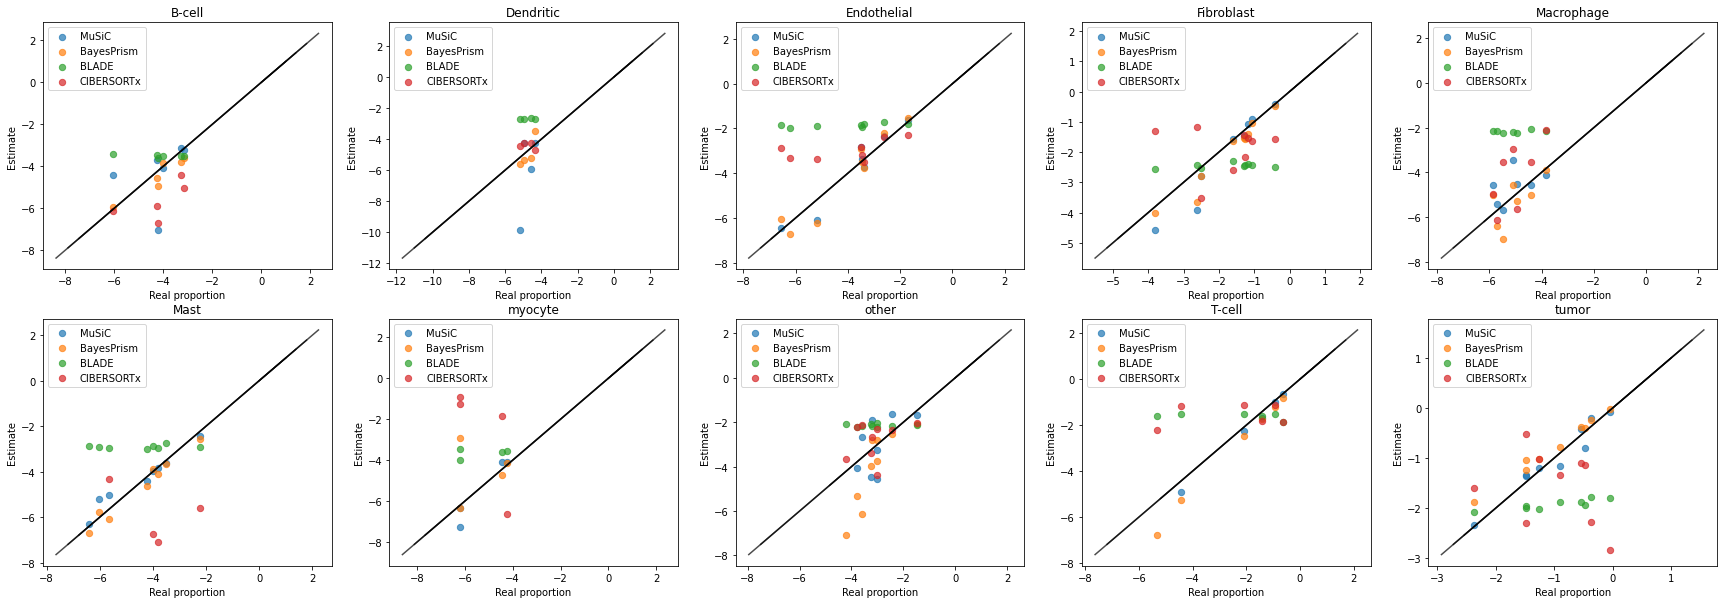

In [26]:
plot_scatter_percelltype_merged([MuSiC_top50m_mean,BayesPrism_top50m_mean,BLADE_top50m_mean,CIBERSORTx_top50m_mean],real_res)

/tmp/ipykernel_28373/3016401405.py:18: RuntimeWarning: divide by zero encountered in log
  x = np.log(list_ax[pic][0])
/tmp/ipykernel_28373/3016401405.py:19: RuntimeWarning: divide by zero encountered in log
  y = np.log(list_ax[pic][1])


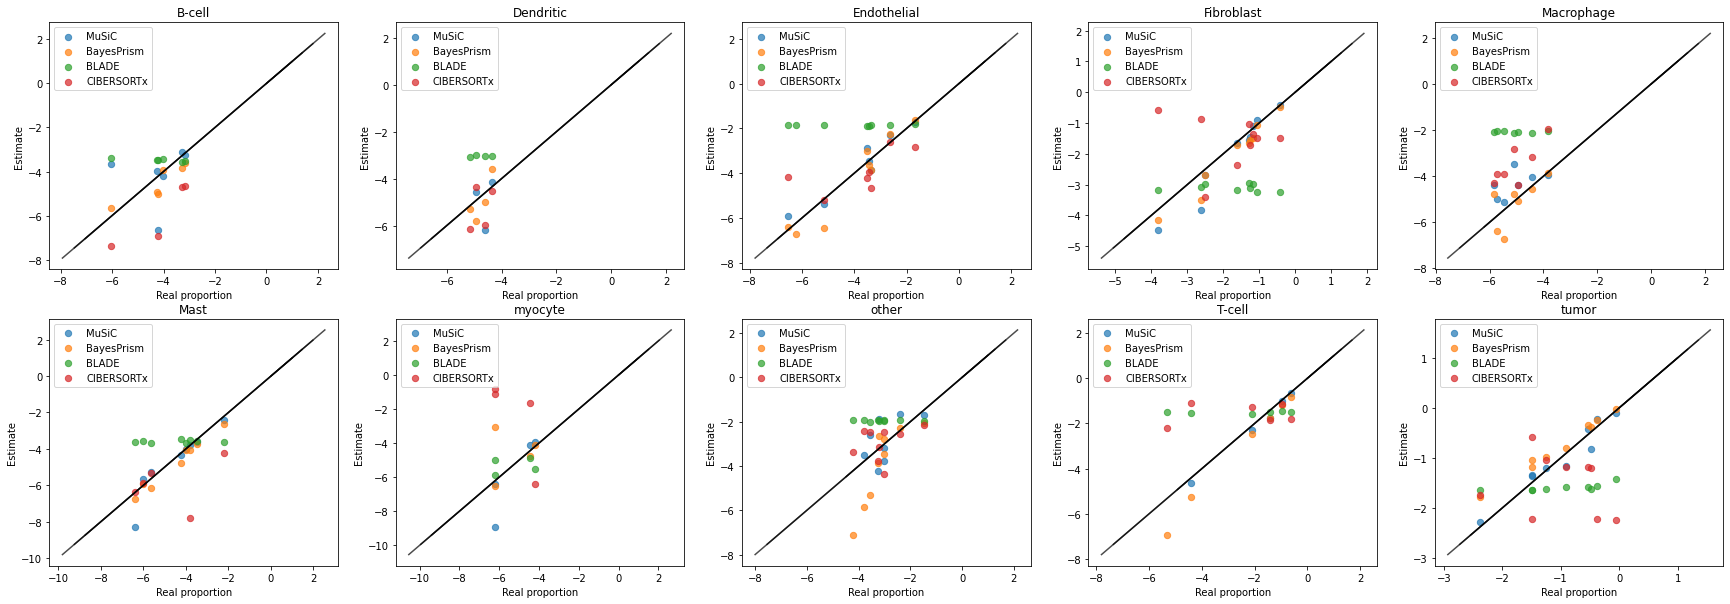

In [27]:
plot_scatter_percelltype_merged([MuSiC_top100m_mean,BayesPrism_top100m_mean,BLADE_top100m_mean,CIBERSORTx_top100m_mean],real_res)

/tmp/ipykernel_28373/3016401405.py:18: RuntimeWarning: divide by zero encountered in log
  x = np.log(list_ax[pic][0])
/tmp/ipykernel_28373/3016401405.py:19: RuntimeWarning: divide by zero encountered in log
  y = np.log(list_ax[pic][1])


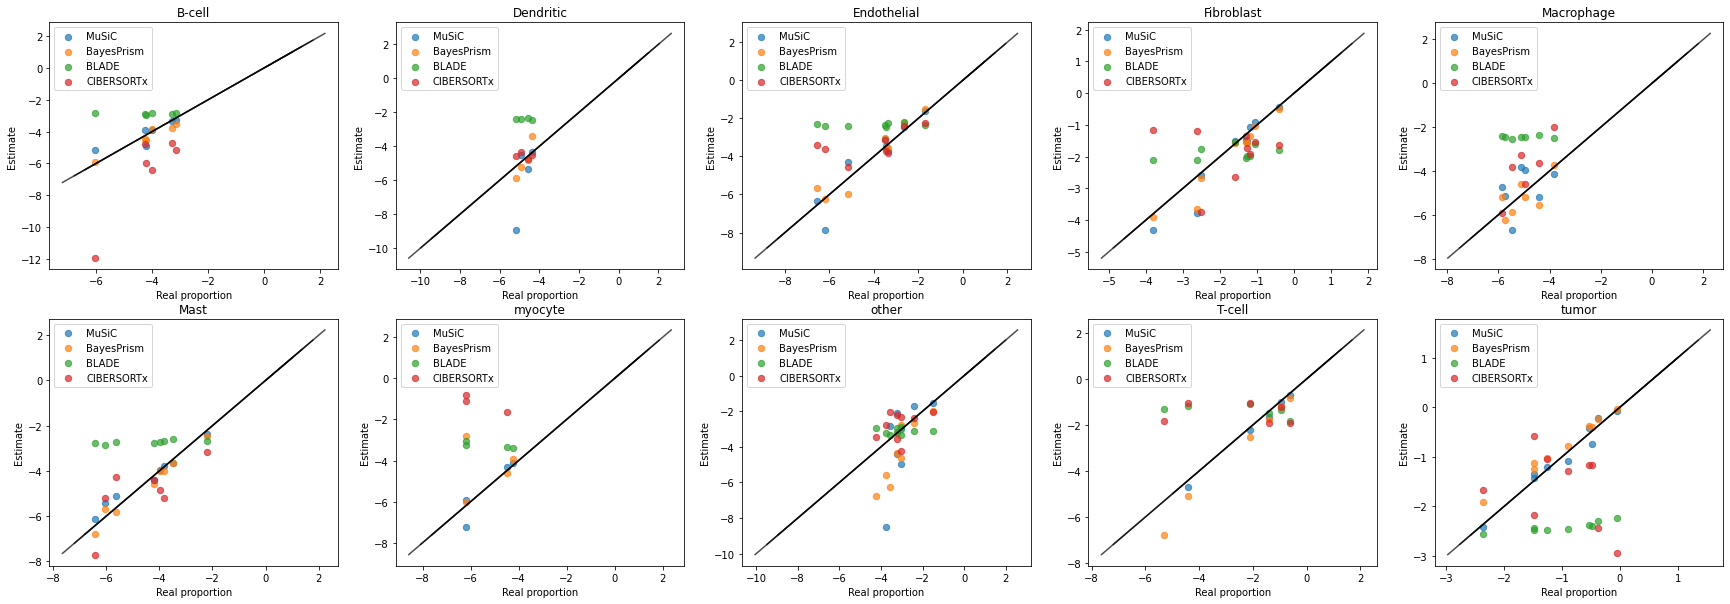

In [28]:
plot_scatter_percelltype_merged([MuSiC_top20m_mean,BayesPrism_top20m_mean,BLADE_top20m_mean,CIBERSORTx_top20m_mean],real_res)

/tmp/ipykernel_28373/3016401405.py:18: RuntimeWarning: divide by zero encountered in log
  x = np.log(list_ax[pic][0])
/tmp/ipykernel_28373/3016401405.py:19: RuntimeWarning: divide by zero encountered in log
  y = np.log(list_ax[pic][1])


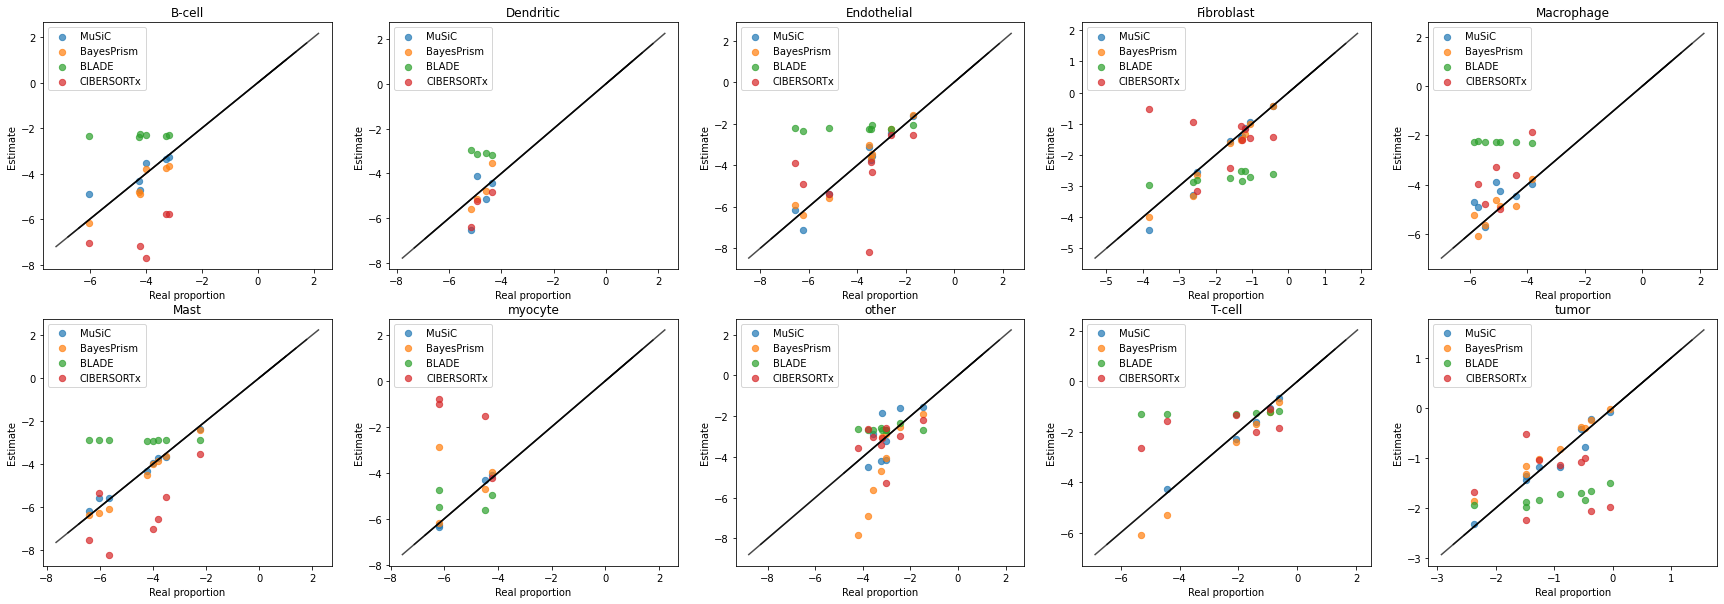

In [29]:
plot_scatter_percelltype_merged([MuSiC_top100D_mean,BayesPrism_top100D_mean,BLADE_top100D_mean,CIBERSORTx_top100D_mean],real_res)

/tmp/ipykernel_28373/3016401405.py:18: RuntimeWarning: divide by zero encountered in log
  x = np.log(list_ax[pic][0])
/tmp/ipykernel_28373/3016401405.py:19: RuntimeWarning: divide by zero encountered in log
  y = np.log(list_ax[pic][1])


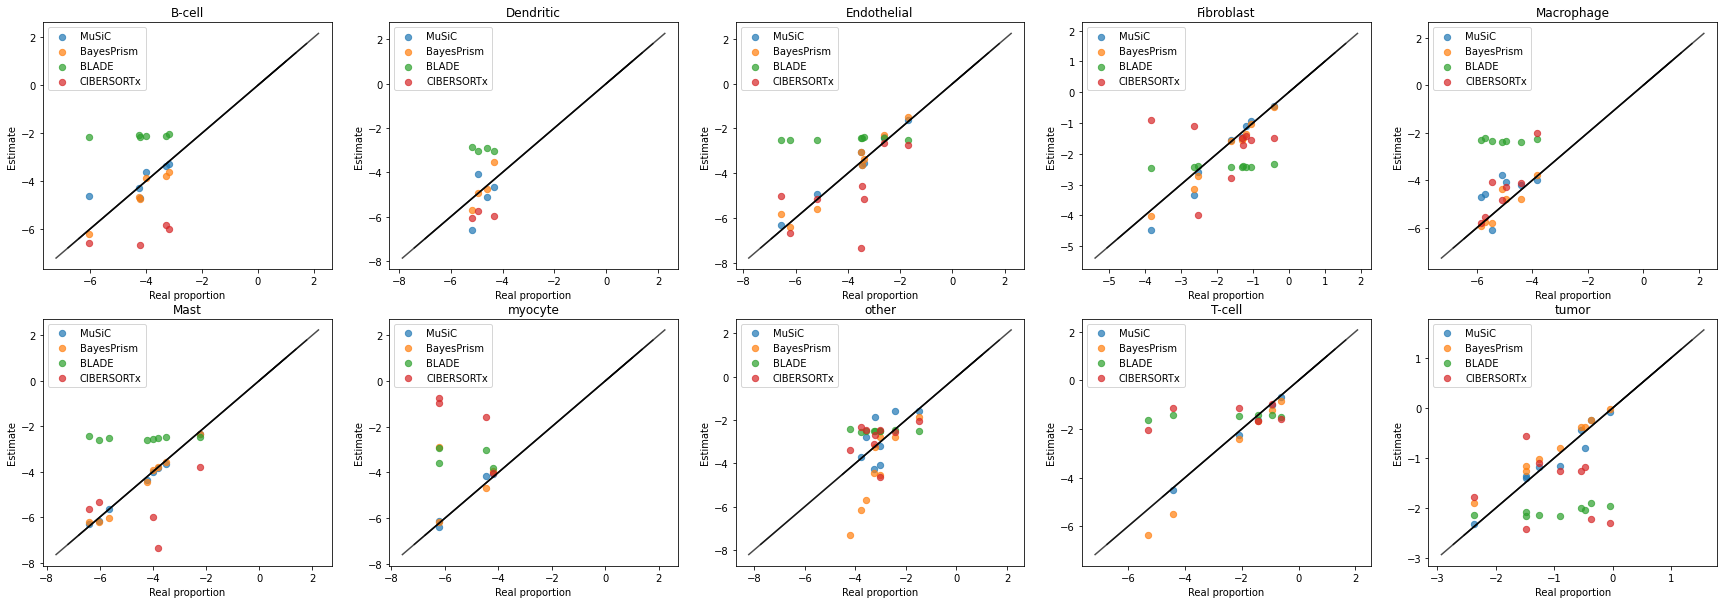

In [30]:
plot_scatter_percelltype_merged([MuSiC_top50D_mean,BayesPrism_top50D_mean,BLADE_top50D_mean,CIBERSORTx_top50D_mean],real_res)

In [133]:
list_res_real

['/home/cke/Real/TCGAResults/BLADE/test_fullpipeline_real_Jul21_real_celltypefrac_BLADEout_top100DEGs.csv',
 '/home/cke/Real/TCGAResults/BLADE/test_fullpipeline_real_Jul21_real_celltypefrac_BLADEout_top100markers.csv',
 '/home/cke/Real/TCGAResults/BLADE/test_fullpipeline_real_Jul21_real_celltypefrac_BLADEout_top20markers.csv',
 '/home/cke/Real/TCGAResults/BLADE/test_fullpipeline_real_Jul21_real_celltypefrac_BLADEout_top50markers.csv',
 '/home/cke/Real/TCGAResults/CIBERSORTx/CIBERSORTx_real_top100DEGs_celltypefrac.csv',
 '/home/cke/Real/TCGAResults/CIBERSORTx/CIBERSORTx_real_top50DEGs_celltypefrac.csv',
 '/home/cke/Real/TCGAResults/CIBERSORTx/CIBERSORTx_real_top50markers_celltypefrac.csv',
 '/home/cke/Real/TCGAResults/CIBERSORTx/CIBERSORTx_real_top20markers_celltypefrac.csv',
 '/home/cke/Real/TCGAResults/CIBERSORTx/CIBERSORTx_real_top100markers_celltypefrac.csv',
 '/home/cke/Real/TCGAResults/BayesPrism/celltypefrac_BP_test_fullpipeline_real_Jul21_real_top100markers.csv',
 '/home/cke/Rea

In [132]:
list_FSsetup = ['top100markers','top50markers','top20markers','top100DEGs','top50DEGs']
list_method = ['BLADE','MuSiC','BayesPrism','CIBERSORTx']

In [261]:
dict_res_real = {}
for res in list_res_real:
#     print(res)
    for method in list_method:
        dict_res_real[method] = {}
            
for res in list_res_real:            
    for method in list_method:        
        for FSsetup in list_FSsetup:
            if FSsetup in res and method in res:
                print(method, FSsetup)
                print("matched!")
                df_celltypefrac = pd.read_csv(res,index_col=0)
                df_celltypefrac['sample'] = df_celltypefrac.index.tolist()
                df_celltypefrac['sample'] = df_celltypefrac['sample'].str.replace('.','-').str.rstrip('A')
                dict_res_real[method][FSsetup] = df_celltypefrac

BLADE top100DEGs
matched!
BLADE top100markers
matched!
BLADE top20markers
matched!
BLADE top50DEGs
matched!
BLADE top50markers
matched!
CIBERSORTx top100DEGs
matched!
CIBERSORTx top50DEGs
matched!
CIBERSORTx top50markers
matched!
CIBERSORTx top20markers
matched!
CIBERSORTx top100markers
matched!
BayesPrism top100markers
matched!
BayesPrism top50DEGs
matched!
BayesPrism top50markers
matched!
BayesPrism top100DEGs
matched!
BayesPrism top20markers
matched!
MuSiC top50markers
matched!
MuSiC top100markers
matched!
MuSiC top100DEGs
matched!
MuSiC top20markers
matched!
MuSiC top50DEGs
matched!


/tmp/ipykernel_5364/3255430753.py:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_celltypefrac['sample'] = df_celltypefrac['sample'].str.replace('.','-').str.rstrip('A')
/tmp/ipykernel_5364/3255430753.py:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_celltypefrac['sample'] = df_celltypefrac['sample'].str.replace('.','-').str.rstrip('A')
/tmp/ipykernel_5364/3255430753.py:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_celltypefrac['sample'] = df_celltypefrac['sample'].str.replace('.','-').str.rstrip('A')
/

In [139]:
dict_res_real

{'BLADE': {'top100DEGs':                     B cell  Dendritic  Endothelial  Fibroblast  Macrophage  \
  TCGA-BB-4224-01A  0.185037   0.018104     0.023619    0.018233    0.044164   
  TCGA-H7-7774-01A  0.156860   0.012243     0.019666    0.152947    0.051249   
  TCGA-CV-6943-01A  0.185959   0.018617     0.073528    0.016362    0.186221   
  TCGA-CN-5374-01A  0.172208   0.024652     0.051930    0.037615    0.049430   
  TCGA-CQ-6227-01A  0.153887   0.011858     0.051660    0.138576    0.032718   
  ...                    ...        ...          ...         ...         ...   
  TCGA-CV-7235-01A  0.183241   0.022859     0.025806    0.025671    0.091283   
  TCGA-CX-7086-01A  0.174087   0.016057     0.023727    0.025931    0.045321   
  TCGA-CV-6935-11A  0.186429   0.016722     0.027962    0.013983    0.054928   
  TCGA-P3-A6SW-01A  0.193995   0.020122     0.036524    0.026500    0.080083   
  TCGA-HD-A6HZ-01A  0.191503   0.014638     0.026817    0.022228    0.078670   
  
              

In [153]:
cellularity_Kari = pd.read_csv("/home/cke/KariPDF/cellularity_table.csv",header=None)
cellularity_Kari.columns = ['sample','cellularity']
cellularity_Kari = cellularity_Kari[cellularity_Kari['cellularity']<1.0]
cellularity_Kari

,sample,cellularity
0,TCGA-CR-7391-01,0.05
1,TCGA-CN-6995-01,0.34
2,TCGA-CQ-A4C6-01,0.26
3,TCGA-CV-A6K0-01,0.10
4,TCGA-CR-6471-01,0.46
...,...,...
519,TCGA-CN-4725-01,0.52
520,TCGA-CV-7440-01,0.40
521,TCGA-CN-4726-01,0.40
522,TCGA-CN-A6V6-01,0.54


In [347]:
# read in processed raw TCGA counts
df_TCGA_symbol = pd.read_csv("/home/cke/TCGA-HNSC.htseq_counts_exp2_symbol.tsv",sep='\t')
df_TCGA_t = df_TCGA_symbol.T
df_TCGA_t.columns = df_TCGA_t.loc['Gene_symbol',:]
df_TCGA_t.drop('Gene_symbol',axis=0,inplace=True)
df_TCGA_t

Gene_symbol,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,LINC00550,LINC01394,LINC00602,MIR1291,LINC00891,PAUPAR,GIMAP1-GIMAP5,LINC02246,HERC2P7,LINC01144
TCGA-BB-4224-01A,2237.0,2.0,1606.0,1063.0,1208.0,256.0,177.0,2371.0,2741.0,2515.0,...,6.0,7.0,0.0,2.0,0.0,6.0,0.0,16.0,0.0,144.0
TCGA-H7-7774-01A,2740.0,0.0,1691.0,803.0,317.0,330.0,5472.0,2316.0,8370.0,816.0,...,0.0,1.0,0.0,0.0,2.0,0.0,0.0,6.0,0.0,23.0
TCGA-CV-6943-01A,2686.0,0.0,1649.0,917.0,402.0,1535.0,15358.0,3490.0,4671.0,2080.0,...,0.0,4.0,0.0,2.0,4.0,1.0,0.0,38.0,0.0,18.0
TCGA-CN-5374-01A,2086.0,1.0,2333.0,1288.0,1105.0,639.0,5565.0,2065.0,2902.0,1777.0,...,0.0,0.0,1.0,0.0,3.0,0.0,0.0,4.0,0.0,31.0
TCGA-CQ-6227-01A,10167.0,9.0,3021.0,537.0,459.0,362.0,6963.0,4883.0,3140.0,2448.0,...,1.0,3.0,0.0,0.0,2.0,0.0,0.0,15.0,0.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-CV-7235-01A,492.0,0.0,976.0,376.0,363.0,488.0,5178.0,2138.0,20007.0,4131.0,...,0.0,2.0,2.0,1.0,0.0,0.0,0.0,8.0,0.0,60.0
TCGA-CX-7086-01A,2741.0,0.0,1952.0,1003.0,1103.0,214.0,1809.0,2639.0,13623.0,2530.0,...,2.0,2.0,0.0,1.0,0.0,1.0,0.0,11.0,0.0,77.0
TCGA-CV-6935-11A,8492.0,3.0,1578.0,818.0,281.0,419.0,7368.0,1355.0,2276.0,1583.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,12.0,0.0,19.0
TCGA-P3-A6SW-01A,770.0,1.0,1569.0,620.0,591.0,462.0,2082.0,1603.0,31675.0,1473.0,...,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,22.0


In [349]:
df_TCGA_t['sample'] = df_TCGA_t.index.tolist()
df_TCGA_t['sample'] = df_TCGA_t['sample'].str.replace('.','-').str.rstrip('A')
df_TCGA_t

/tmp/ipykernel_5364/1890542009.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_TCGA_t['sample'] = df_TCGA_t['sample'].str.replace('.','-').str.rstrip('A')


Gene_symbol,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,LINC01394,LINC00602,MIR1291,LINC00891,PAUPAR,GIMAP1-GIMAP5,LINC02246,HERC2P7,LINC01144,sample
TCGA-BB-4224-01A,2237.0,2.0,1606.0,1063.0,1208.0,256.0,177.0,2371.0,2741.0,2515.0,...,7.0,0.0,2.0,0.0,6.0,0.0,16.0,0.0,144.0,TCGA-BB-4224-01
TCGA-H7-7774-01A,2740.0,0.0,1691.0,803.0,317.0,330.0,5472.0,2316.0,8370.0,816.0,...,1.0,0.0,0.0,2.0,0.0,0.0,6.0,0.0,23.0,TCGA-H7-7774-01
TCGA-CV-6943-01A,2686.0,0.0,1649.0,917.0,402.0,1535.0,15358.0,3490.0,4671.0,2080.0,...,4.0,0.0,2.0,4.0,1.0,0.0,38.0,0.0,18.0,TCGA-CV-6943-01
TCGA-CN-5374-01A,2086.0,1.0,2333.0,1288.0,1105.0,639.0,5565.0,2065.0,2902.0,1777.0,...,0.0,1.0,0.0,3.0,0.0,0.0,4.0,0.0,31.0,TCGA-CN-5374-01
TCGA-CQ-6227-01A,10167.0,9.0,3021.0,537.0,459.0,362.0,6963.0,4883.0,3140.0,2448.0,...,3.0,0.0,0.0,2.0,0.0,0.0,15.0,0.0,24.0,TCGA-CQ-6227-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-CV-7235-01A,492.0,0.0,976.0,376.0,363.0,488.0,5178.0,2138.0,20007.0,4131.0,...,2.0,2.0,1.0,0.0,0.0,0.0,8.0,0.0,60.0,TCGA-CV-7235-01
TCGA-CX-7086-01A,2741.0,0.0,1952.0,1003.0,1103.0,214.0,1809.0,2639.0,13623.0,2530.0,...,2.0,0.0,1.0,0.0,1.0,0.0,11.0,0.0,77.0,TCGA-CX-7086-01
TCGA-CV-6935-11A,8492.0,3.0,1578.0,818.0,281.0,419.0,7368.0,1355.0,2276.0,1583.0,...,1.0,0.0,1.0,0.0,0.0,0.0,12.0,0.0,19.0,TCGA-CV-6935-11
TCGA-P3-A6SW-01A,770.0,1.0,1569.0,620.0,591.0,462.0,2082.0,1603.0,31675.0,1473.0,...,0.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,22.0,TCGA-P3-A6SW-01


In [367]:
merged_TCGA_cellularity = pd.merge(df_TCGA_t,cellularity_Kari,left_on='sample',right_on='sample',how='inner')
merged_TCGA_cellularity

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,LINC00602,MIR1291,LINC00891,PAUPAR,GIMAP1-GIMAP5,LINC02246,HERC2P7,LINC01144,sample,cellularity
0,2237.0,2.0,1606.0,1063.0,1208.0,256.0,177.0,2371.0,2741.0,2515.0,...,0.0,2.0,0.0,6.0,0.0,16.0,0.0,144.0,TCGA-BB-4224-01,0.59
1,2740.0,0.0,1691.0,803.0,317.0,330.0,5472.0,2316.0,8370.0,816.0,...,0.0,0.0,2.0,0.0,0.0,6.0,0.0,23.0,TCGA-H7-7774-01,0.48
2,2686.0,0.0,1649.0,917.0,402.0,1535.0,15358.0,3490.0,4671.0,2080.0,...,0.0,2.0,4.0,1.0,0.0,38.0,0.0,18.0,TCGA-CV-6943-01,0.19
3,2086.0,1.0,2333.0,1288.0,1105.0,639.0,5565.0,2065.0,2902.0,1777.0,...,1.0,0.0,3.0,0.0,0.0,4.0,0.0,31.0,TCGA-CN-5374-01,0.36
4,10167.0,9.0,3021.0,537.0,459.0,362.0,6963.0,4883.0,3140.0,2448.0,...,0.0,0.0,2.0,0.0,0.0,15.0,0.0,24.0,TCGA-CQ-6227-01,0.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,2218.0,0.0,1574.0,852.0,729.0,550.0,5558.0,2921.0,8749.0,1596.0,...,0.0,0.0,2.0,0.0,0.0,17.0,0.0,54.0,TCGA-CN-6010-01,0.36
480,492.0,0.0,976.0,376.0,363.0,488.0,5178.0,2138.0,20007.0,4131.0,...,2.0,1.0,0.0,0.0,0.0,8.0,0.0,60.0,TCGA-CV-7235-01,0.40
481,2741.0,0.0,1952.0,1003.0,1103.0,214.0,1809.0,2639.0,13623.0,2530.0,...,0.0,1.0,0.0,1.0,0.0,11.0,0.0,77.0,TCGA-CX-7086-01,0.61
482,770.0,1.0,1569.0,620.0,591.0,462.0,2082.0,1603.0,31675.0,1473.0,...,2.0,1.0,1.0,0.0,0.0,0.0,1.0,22.0,TCGA-P3-A6SW-01,0.28


In [ ]:
merged_TCGA_cellularity.drop('sample',axis=1).astype('float64').corr()

In [ ]:
dict_gene_cellularity = {}
for i in tqdm(merged_TCGA_cellularity.columns):
    dict_gene_cellularity[i] = np.corrcoef(merged_TCGA_cellularity[i].tolist(),merged_TCGA_cellularity['cellularity'])[1,0]

In [27]:
def plot_estimates_cellularity(method_celltypefrac,cellularity_Kari):
    celltype_cellularity = pd.merge(method_celltypefrac,cellularity_Kari,on='sample')
    celltype_cellularity.plot('cellularity','tumor',kind='scatter',xlabel='DNA cellularity',ylabel='Estimated tumor percentage')
    pearsoncorr = pearsonr(celltype_cellularity['tumor'],celltype_cellularity['cellularity'])[0]
    rmse = mean_squared_error(celltype_cellularity['cellularity'], celltype_cellularity['tumor'], squared=False)
    r2 = r2_score(celltype_cellularity['cellularity'], celltype_cellularity['tumor'])
    print('Pearson\'s correlation: ',pearsoncorr,'rmse: ',rmse ,"r2 score: ",r2)
    return celltype_cellularity,pearsoncorr,rmse

In [254]:
list_FSsetup

['top100markers', 'top50markers', 'top20markers', 'top100DEGs', 'top50DEGs']

Pearson's correlation:  0.31645102656323215 rmse:  0.3787207299474337 r2 score:  -3.9614233433586987
top100markers
Pearson's correlation:  0.3148401967890541 rmse:  0.39060730024789325 r2 score:  -4.277750333982012
top50markers
Pearson's correlation:  0.2846674209398581 rmse:  0.3882031284749012 r2 score:  -4.2129816038059635
top20markers
Pearson's correlation:  0.3362549330940758 rmse:  0.34816155247629077 r2 score:  -3.1930471968420138
top100DEGs
Pearson's correlation:  0.33961146781966983 rmse:  0.3587358952633958 r2 score:  -3.451617073802578
top50DEGs


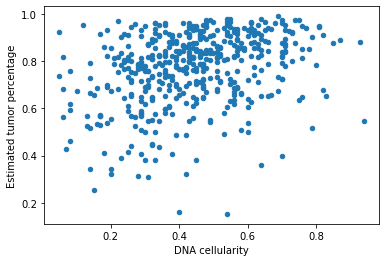

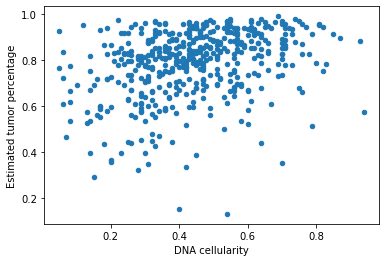

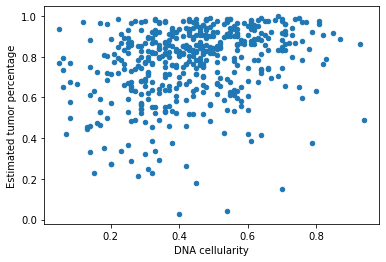

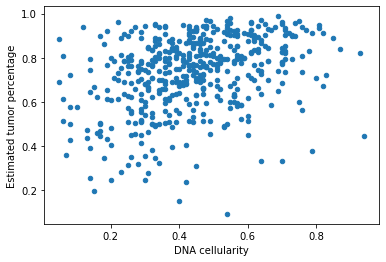

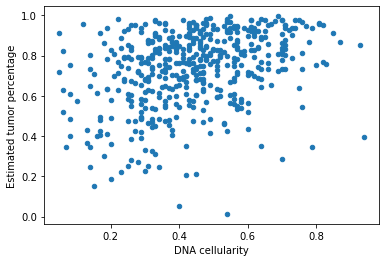

In [343]:
list_BP_pearson = []
list_BP_rmse = []
for FSsetup in list_FSsetup:
    BP_celltype_cellularity,BP_pearsoncorr,BP_rmse = plot_estimates_cellularity(dict_res_real['BayesPrism'][FSsetup],cellularity_Kari)
    list_BP_pearson.append(BP_pearsoncorr)
    list_BP_rmse.append(BP_rmse)
    print(FSsetup)

Pearson's correlation:  0.19740696347286166 rmse:  0.3936682013706456 r2 score:  -4.360790093008632
Pearson's correlation:  0.204922464447828 rmse:  0.41273914222643643 r2 score:  -4.89276938080533
Pearson's correlation:  0.10313112213733674 rmse:  0.48451392719680614 r2 score:  -7.120460549307843
Pearson's correlation:  0.23609160385266084 rmse:  0.43103464726355 r2 score:  -5.426766068770177
Pearson's correlation:  0.2203324576900545 rmse:  0.4526160551974253 r2 score:  -6.0864387987835045


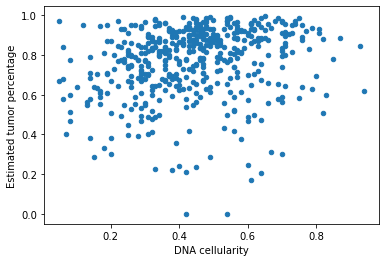

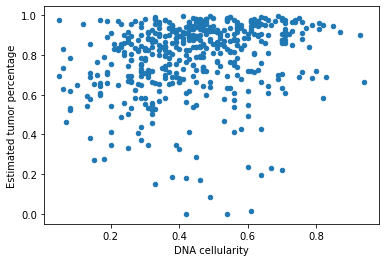

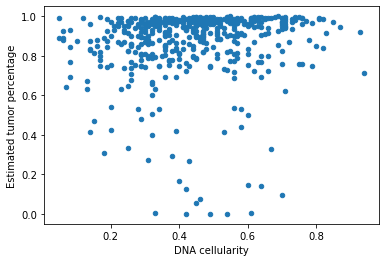

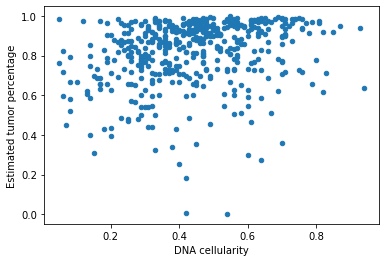

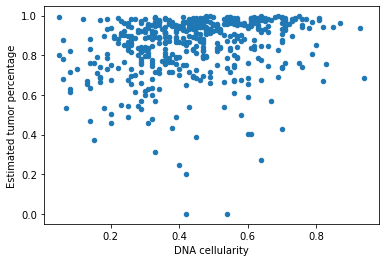

In [255]:
list_MuSiC_pearson = []
list_MuSiC_rmse = []
for FSsetup in list_FSsetup:
    celltype_cellularity,pearsoncorr,rmse = plot_estimates_cellularity(dict_res_real['MuSiC'][FSsetup],cellularity_Kari)
    list_MuSiC_pearson.append(pearsoncorr)
    list_MuSiC_rmse.append(rmse)

Pearson's correlation:  0.022755980440028967 rmse:  0.23462077675917348 r2 score:  -0.904149604708522
Pearson's correlation:  -0.021635073650866154 rmse:  0.2799826543080613 r2 score:  -1.7116297077550193
Pearson's correlation:  -0.04481602200536724 rmse:  0.3102027461872259 r2 score:  -2.3285831232625087
Pearson's correlation:  0.04513224443396663 rmse:  0.21252466545168414 r2 score:  -0.5623805103077297
Pearson's correlation:  0.04328826082395895 rmse:  0.29529363593509256 r2 score:  -2.0163122992503877


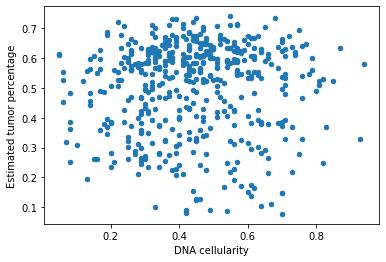

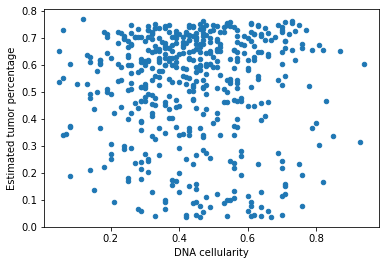

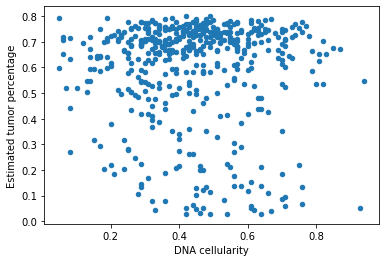

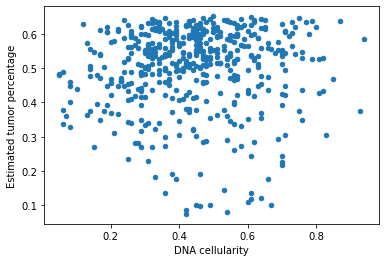

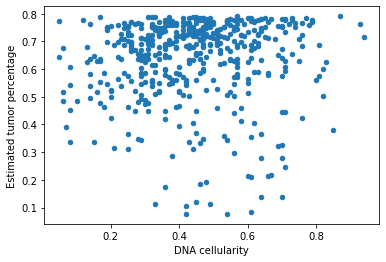

In [262]:
list_BLADE_pearson = []
list_BLADE_rmse = []
for FSsetup in list_FSsetup:
    celltype_cellularity,pearsoncorr,rmse = plot_estimates_cellularity(dict_res_real['BLADE'][FSsetup],cellularity_Kari)
    list_BLADE_pearson.append(pearsoncorr)
    list_BLADE_rmse.append(rmse)

Pearson's correlation:  0.09844702312262871 rmse:  0.37339628031245425 r2 score:  -3.8228983095916806
Pearson's correlation:  0.09339065286553451 rmse:  0.38266871111960055 r2 score:  -4.065403400788264
Pearson's correlation:  0.02059007435648568 rmse:  0.41230661957494574 r2 score:  -4.8804254060538295
Pearson's correlation:  0.15939691352011048 rmse:  0.40394703660360753 r2 score:  -4.644389603688136
Pearson's correlation:  0.10237530781631163 rmse:  0.42888866051167684 r2 score:  -5.3629316530890705


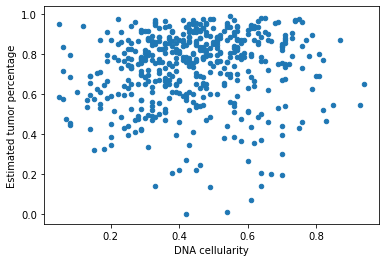

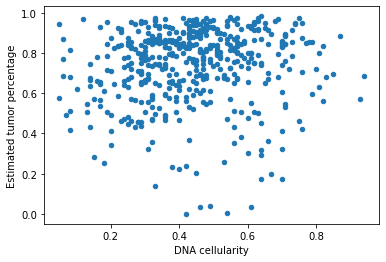

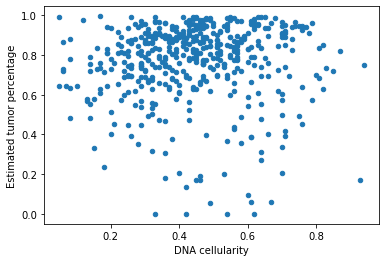

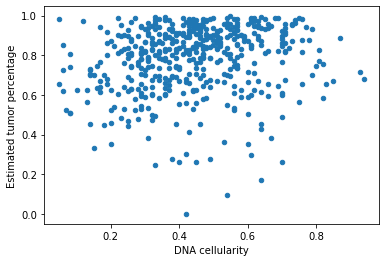

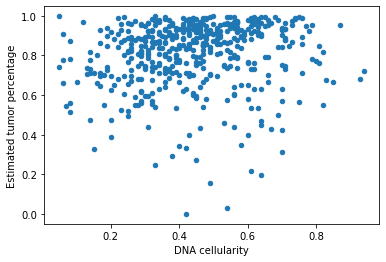

In [263]:
list_CIBERSORTx_pearson = []
list_CIBERSORTx_rmse = []
for FSsetup in list_FSsetup:
    celltype_cellularity,pearsoncorr,rmse = plot_estimates_cellularity(dict_res_real['CIBERSORTx'][FSsetup],cellularity_Kari)
    list_CIBERSORTx_pearson.append(pearsoncorr)
    list_CIBERSORTx_rmse.append(rmse)